# 🌼 주가 예측 모델 만들기

---

야후 파이넌스에서 크롤링 한 데이터를 제공하는 라이브러리로서, 미국 주식부터 국내 주식의 주가 데이터를 가지고 올 수 있습니다.

실제 과거의 주식 데이터를 가지고 LSTM을 활용하여 예측하는 모델을 구현할 것입니다.

In [1]:
# 필요 라이브러리 설치
%pip install yfinance
%pip install tensorflow
%pip install matplotlib

  Using cached lxml-5.3.0-cp39-cp39-win_amd64.whl.metadata (3.9 kB)
     ---------------------------------------- 0.0/948.2 kB ? eta -:--:--
     ------------------------------------- 948.2/948.2 kB 22.1 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
Using cached lxml-5.3.0-cp39-cp39-win_amd64.whl (3.8 MB)
  Created wheel for peewee: filename=peewee-3.17.8-py3-none-any.whl size=139013 sha256=33721885b0f34bc1e1ef41f36c74dccbb31ab474139612868e0773f0aeab2503
  Stored in directory: c:\users\rmarket\appdata\local\pip\cache\wheels\06\b3\7f\ed42a7c83ad89f578928833f5789212c694a015b8bd6a407a1
Successfully built peewee
Note: you may need to restart the kernel to use updated packages.
Note: you may nee

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

In [3]:
# 미국 주식
apple = yf.Ticker("AAPL") # 애플
tesla = yf.Ticker("TSLA") # 테슬라
google = yf.Ticker('GOOGL') # 구글
microsoft = yf.Ticker('MSFT') # 마이크로소프트
nvidia = yf.Ticker('NVDA') # NVIDIA
netflix = yf.Ticker('NFLX') # 넷플릭스

# 국내 주식
samsung = yf.Ticker("005930.KS") # 삼성전자
hynix = yf.Ticker("000660.KS") # SK하이닉스
naver = yf.Ticker("035420.KS") # 네이버
kakao = yf.Ticker("035720.KS") # 카카오
hyundai = yf.Ticker("005380.KS") # 현대자동차
lg = yf.Ticker("066570.KS") # LG전자

period에 들어갈 수 있는 값은 "1d",  "5d",  "1mo",  "3mo",  "6mo",  "1y",  "2y",  "5y",  "10y",  "ytd",  "max" 입니다.

ytd = '올해 1월1일부터 최근 데이터'

In [ ]:
# 주가 데이터 가져오기
period_data = samsung.history(period="1d")  # 지난 1년 데이터 , (period : 데이터의 기간을 설정)
print(period_data)

                              Open     High      Low    Close    Volume  \
Date                                                                      
2024-11-14 00:00:00+09:00  50200.0  51800.0  50200.0  51200.0  27028332   

                           Dividends  Stock Splits  
Date                                                
2024-11-14 00:00:00+09:00        0.0           0.0  


- Open : 해당일 첫 번째 거래 가격

- High : 해당일 최고 거래 가격

- Low : 해당일 최저 거래 가격

- Close : 해당일 마지막 거래 가격

- Volume : 해당일 거래 주식 총 수량

In [ ]:
# 주식 데이터 추출 함수
def StockData(ticker, date):
    df = ticker.history(start=date) # history() : 주식 데이터를 특정 기간 동안 기록으로 가져오는 함수
    df = df[['Open', 'High', 'Low', 'Volume', 'Close']] # 주가 예측에 필요없는 Dividends, Stock Splits는 제외하고 가져옵니다
    return df

In [7]:
# 삼성전자 데이터를 2023년 1월 1일부터 가져옵니다
samsung_data = StockData(samsung, "2023-01-01")

In [8]:
samsung_data

,Open,High,Low,Volume,Close
Date,,,,,
2023-01-02 00:00:00+09:00,53576.578125,54155.784375,53286.975000,10031448,53576.578125
2023-01-03 00:00:00+09:00,53480.046875,54059.253159,52611.237449,13547030,53480.046875
2023-01-04 00:00:00+09:00,53769.649134,55989.939852,53673.114755,20188071,55796.871094
2023-01-05 00:00:00+09:00,56183.007812,56762.214079,55603.801546,15682826,56183.007812
2023-01-06 00:00:00+09:00,56279.544485,57341.422683,55893.406958,17334989,56955.285156
...,...,...,...,...,...
2024-11-08 00:00:00+09:00,58000.000000,58300.000000,57000.000000,13877396,57000.000000
2024-11-11 00:00:00+09:00,56700.000000,56800.000000,55000.000000,29811326,55000.000000
2024-11-12 00:00:00+09:00,54600.000000,54600.000000,53000.000000,37962881,53000.000000


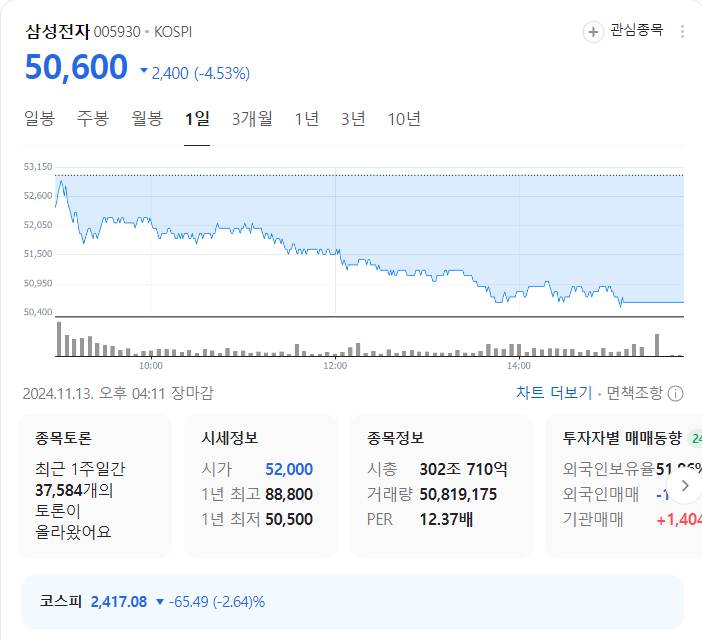

In [ ]:
# 정규화 함수
def MinMaxScaler(data):
    numerator = data - np.min(data, 0) # np.min(data, 0) = np.min(data, axis=0) : 열방향 기준
    denominator = np.max(data, 0) - np.min(data, 0)
    # 데이터가 모두 동일한 값을 가질 때, denominator가 0이 되어 나누기 0 오류가 발생할 수 있다.(이걸 방지하기 위해 le-7 사용)
    return numerator / (denominator + 1e-7) 
    # 각 데이터 포인트가 최소값에서 얼마나 떨어져 있는지를, 전체 데이터에서 얼마나 차이가 나는지를 비율로 나타내는 과정(0으로 나누는 오류를 방지:ZeroDivisionError)
    # le-7(0.0000007) : 매우 작은 값이지만 0과 정확히 같지 않으므로, 계산에서 오류를 방지하면서 수치적으로 안정적인 처리를 보장합니다.

In [10]:
3/0

ZeroDivisionError: division by zero

In [21]:
samsung_data_x = MinMaxScaler(samsung_data) # 정규화 : 각 데이터의 값을 0과 1 사이로 변환
samsung_data_y = samsung_data_x[['Close']] # 해당일 마지막 거래 가격을 예측 할 값으로 분리

# 리스트 형태 변환
x = samsung_data_x.values.tolist()
y = samsung_data_y.values.tolist()

In [22]:
# 슬라이딩 윈도우
data_x = []
data_y = []
window_size = 10     # 이전 10일 Open, High, Low, Volume, Close 데이터로 다음 날 종가 예측
# window_size : 과거 며칠간의 데이터를 사용하여 다음 날의 값을 예측할 것인지 결정하는 값
for i in range(len(y) - window_size): # len(y) - window_size : 마지막 데이터까지 예측하기 위해 사용
    x2 = x[i : i + window_size] # 10일치 데이터
    y2 = y[i + window_size] # 11일째 날 데이터
    data_x.append(x2)
    data_y.append(y2)

In [23]:
# 시간의 흐름에 따라 분석하는 데이터이기 때문에 랜덤이 아니라 순차적으로 데이터를 나눔
# 훈련용 데이터셋 80%
train_size = int(len(data_y) * 0.8)
train_x = np.array(data_x[0:train_size])
train_y = np.array(data_y[0:train_size])

# 테스트용 데이터셋 20%
test_size = len(data_y) - train_size
test_x = np.array(data_x[train_size:len(data_x)])
test_y = np.array(data_y[train_size:len(data_y)])

In [24]:
# 데이터 count
print(train_size)
print(test_size)

358
90


In [31]:
model = Sequential()

# 첫 번째 LSTM 층
model.add(LSTM(64, return_sequences=True, input_shape=(window_size, 5), activation='relu'))
# model.add(LSTm(출력차원 수, , input_shape(타임스텝, 특징), 활성화함수 ))

# return_sequences=True -> 모든 타임스텝에 대한 출력을 반환 (배치크기, 타임스텝 수, 출력 차원)
# return_sequences=False(기본값) -> 마지막 타임스텝의 출력만 반환 (배치크기, 출력차원)

# 타입스텝 : 시퀀스에서 시간 순서대로 나열된 데이터의 길이입니다. 즉, 몇 개의 데이터 포인트가 포함되어 있는지를 정의
# 특징 : 각 타임스텝에서 제공되는 속성 값의 수입니다. 각 시간에서 어떤 정보가 모델에 주어지는지를 정의

# 출력노드 20% 비활성화
model.add(Dropout(0.2)) # 과적합을 방지하기 위해 출력 노드의 20%를 무작위로 비활성화

# 두 번째 LSTM 층
model.add(LSTM(32, activation='relu'))
# 출력노드 20% 비활성화
model.add(Dropout(0.2))

# 출력층(완전 연결 구조)
model.add(Dense(1))
model.summary() # 모델의 구조와 각 층의 출력 크기, 파라미터 수를 출력

model.compile(optimizer='adam', loss='mean_squared_error') # Optimizer : adam, 손실 함수:MSE
model.fit(train_x, train_y, epochs=100, batch_size=30) # epochs: 전체 데이터 학습 횟수, batch_size: 한 번에 제공되는 훈련 데이터 수
pred_y = model.predict(test_x)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 10, 64)            17920     
                                                                 
 dropout_9 (Dropout)         (None, 10, 64)            0         
                                                                 
 lstm_15 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_10 (Dropout)        (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 30,369
Trainable params: 30,369
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
12/12 [==============================]

In [33]:
# 역정규화 함수
def inverse_MinMaxScaler(normalized_data, original_data):
    original_min = np.min(original_data, 0) # 원본 데이터의 최소값
    original_max = np.max(original_data, 0) # 원본 데이터의 최대값
    return normalized_data * (original_max - original_min) + original_min # 원래의 스케일로 값을 복원하는 공식
    # 정규화된 값에 원본 데이터의 범위 (original_max - original_min)를 곱하고, 그 후 원본 데이터의 최소값(original_min)을 더한다

# 예측값과 실제값을 원래 스케일로 역변환
test_y_original = inverse_MinMaxScaler(test_y, samsung_data['Close'])
pred_y_original = inverse_MinMaxScaler(pred_y, samsung_data['Close'])

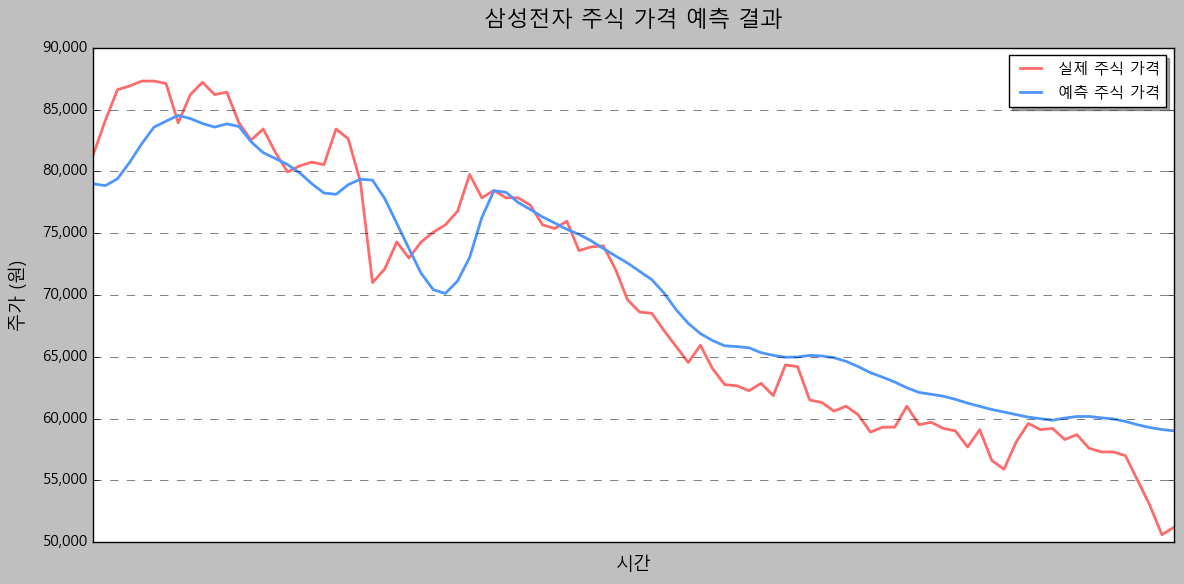

In [34]:
# 그래프 그리기
plt.style.use('classic')
plt.figure(figsize=(12, 6), dpi=100)

# 폰트 설정
plt.rc('font', family='Malgun Gothic', size=12)
plt.rc('axes', titlesize=16, labelsize=13)
plt.rc('xtick', labelsize=11)
plt.rc('ytick', labelsize=11)

# 데이터 플로팅
plt.plot(test_y_original, color='#FF6B6B', linewidth=2, label='실제 주식 가격')
plt.plot(pred_y_original, color='#4D96FF', linewidth=2, label='예측 주식 가격')

# 제목 및 레이블 설정
plt.title('삼성전자 주식 가격 예측 결과', pad=15)
plt.xlabel('시간', labelpad=10)
plt.ylabel('주가 (원)', labelpad=10)

# x축의 숫자 레이블 제거
plt.xticks([])

# 범례 설정
plt.legend(loc='best', frameon=True, shadow=True, fontsize=11)

# 그리드 설정
plt.grid(True, linestyle='--', alpha=0.7)

# y축 포맷 설정 (천 단위 콤마)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

# 여백 자동 조정
plt.tight_layout()

# 그래프 표시
plt.show()

In [ ]:
# 예측 종가 계산
last_price = samsung_data.Close.iloc[-1]  # 실제 마지막 종가
predicted_value = pred_y[-1][0]  # 배열 -> 스칼라 값 변환
# 스칼라 값(scalar value) : 하나의 숫자를 의미(즉, 여러 개의 값이 아닌 단 하나의 값으로 표현되는 수치)
# 벡터 : 여러 개의 숫자가 일렬로 나열된 값입니다. 예를 들어, [1, 2, 3]은 벡터입니다.
# 행렬 : 2D 배열로, 숫자들이 행과 열로 배열된 형태입니다. 예를 들어, [[1, 2], [3, 4]]은 행렬입니다.
# 텐서 : 더 높은 차원의 배열을 나타낼 수 있으며, 3D 이상의 데이터를 다룰 수 있습니다.

# 역정규화
min_price = samsung_data.Close.min()
max_price = samsung_data.Close.max()
scaling_factor = max_price - min_price

# 예측 가격 계산
predicted_price = (predicted_value * scaling_factor) + min_price

print("삼성전자 내일 마지막 거래(종가) 예측 가격 :", format(int(predicted_price), ','),"원")

삼성전자 내일 마지막 거래(종가) 예측 가격 : 59,156 원


In [29]:
predicted_value

0.2330727

### 문제

- 실제 주가 데이터와 예측 데이터를 보면 정확하게 일치하지는 않아도 비슷한 추이가 나타나는 것을 볼 수 있습니다.

- 하지만 해당 모델이 실제로 활용하기 어려운 이유가 무엇일까요?


모델이 실제로 활용하기 어려운 이유는 예측의 정확성 부족과 실제 시장 환경의 변동성 때문입니다. 주식 예측 모델을 실제로 사용하기 어렵게 만드는 몇 가지 이유는 다음과 같습니다:

1. 시장 변동성 (Volatility):
주식 시장은 매우 변동성이 크고 예측하기 어렵습니다. 경제 상황, 정치적 변화, 기업의 실적 발표 등 여러 요인들이 주식 가격에 영향을 미칩니다. 모델이 과거의 데이터를 기반으로 학습하더라도 미래의 예측은 이와 같은 외부 요인에 의해 왜곡될 수 있습니다.
예측된 값이 실제 주가와 비슷한 추이를 보일 수 있지만, 정확한 예측을 지속적으로 내는 것은 매우 어렵습니다.
2. 과적합 (Overfitting):
모델이 과거 데이터를 학습하면서 과적합될 수 있습니다. 즉, 모델이 훈련 데이터에서 너무 잘 맞춰져 있어, 새로운 데이터나 실제 시장 변화에 잘 반응하지 못하는 현상입니다.
훈련 데이터에만 특화된 모델이 실제 데이터를 처리할 때 일반화 능력이 떨어지므로 예측 정확도가 낮을 수 있습니다.
3. 피쳐의 부족 (Insufficient Features):
주식 가격에 영향을 미치는 변수는 많습니다. 예를 들어, 경제 지표, 글로벌 뉴스, 거래량, 기술적 지표 등이 주식의 가격을 결정짓는 중요한 요소입니다.
모델이 단순히 과거의 종가를 예측하는 것에만 의존한다면, 중요한 외부 요인이나 다른 변수들이 반영되지 않아 예측 성능이 제한적일 수 있습니다.
4. 시계열의 특성 (Time Series Characteristics):
주식 데이터는 시계열 데이터로, 시간에 따라 의존성이 존재합니다. 즉, 모델이 시간 순서대로 데이터를 학습하지만 주식 시장의 패턴은 지속적으로 변할 수 있기 때문에, 학습된 패턴이 미래에도 그대로 적용되지 않을 수 있습니다.
데이터 스터디와 학습은 과거에 국한되기 때문에 미래의 돌발 상황이나 급격한 변화에 대응하기 어려울 수 있습니다.
5. 단기 예측 vs 장기 예측:
단기 예측은 상대적으로 더 정확하게 이루어질 수 있지만, 장기 예측은 더욱 어려워집니다. 주식 시장의 변화는 다양한 외부 요인에 영향을 받기 때문에 장기적으로 정확한 예측을 하기가 매우 어렵습니다.
6. 모델의 해석력 부족:
주식 가격을 예측하는 모델은 대개 딥러닝 또는 기계 학습 모델을 사용하여, 예측된 결과가 왜 그런지 해석하기 어려운 경우가 많습니다. 투자자는 예측의 근거와 설명을 이해하고 싶은데, 모델의 블랙박스 성격 때문에 신뢰를 얻기가 어렵습니다.
7. 리스크 관리의 부족:
주식 시장에서는 예측 뿐만 아니라 리스크 관리가 중요합니다. 예측 모델이 올바르게 작동하더라도, 리스크를 적절히 관리하지 않으면 예측이 맞았을 때의 이익보다 예측이 틀렸을 때의 손실이 더 클 수 있습니다. 모델에서 예측된 값만으로 실제 투자 결정을 내리는 것은 매우 위험할 수 있습니다.
결론:
주식 예측 모델은 예측 정확도와 시장 예측의 변동성으로 인해 실제 투자에 바로 적용하기에는 한계가 많습니다. 보다 신뢰성 있는 예측을 위해서는 외부 변수와 다양한 피쳐를 반영하고, 리스크 관리를 잘 하는 방식으로 보완해야 합니다.